<a href="https://colab.research.google.com/github/feist000/Project/blob/master/%EA%B3%A0%EC%96%91%EC%8B%9C%20%EA%B3%B5%EA%B3%B5%EC%9E%90%EC%A0%84%EA%B1%B0%20%EC%8A%A4%ED%85%8C%EC%9D%B4%EC%85%98/%5B%EC%86%8C%EC%8A%A4%EC%BD%94%EB%93%9C%5D%5B%EB%88%84%EA%B0%80_%EB%82%B4_%EC%9E%90%EC%A0%84%EA%B1%B0%EB%A5%BC_%EC%98%AE%EA%B2%BC%EC%9D%84%EA%B9%8C%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 공공 자전거 스테이션 현황
 ##		1) 시간대별 이용 현황 	
 ##		2) 시간대별 사용빈도가  높은 대여/반납 스테이션 위치
 ##    3) 사용량에 따른 자전거스테이션 위치

In [ ]:
import pathlib
import random
from functools import reduce
from collections import defaultdict

import pandas as pd
import geopandas as gpd
import folium
import shapely
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xgboost
import sklearn.cluster
import tensorflow as tf

from geoband import API

/opt/app-root/lib/python3.6/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# 데이터 읽어오기
input_path = pathlib.Path('./input')
if not input_path.is_dir():
    input_path.mkdir()

API.GetCompasData('SBJ_2007_001', '1', input_path.joinpath('01.운영이력.csv'))
API.GetCompasData('SBJ_2007_001', '2', input_path.joinpath('02.자전거스테이션.csv'))
API.GetCompasData('SBJ_2007_001', '6', input_path.joinpath('17.일반건물 분포도(100M X 100M).geojson'))
API.GetCompasData('SBJ_2007_001', '15', input_path.joinpath('15.도로명주소_건물.geojson'))
API.GetCompasData('SBJ_2007_001', '16', input_path.joinpath('16.도로명주소_도로.geojson'))
API.GetCompasData('SBJ_2007_001', '19', input_path.joinpath('19.전철역_공간정보.csv'))
API.GetCompasData('SBJ_2007_001', '20', input_path.joinpath('20.고양시 버스정류소.csv'))

for path in list(input_path.glob('*.csv')) + list(input_path.glob('*.geojson')):
    print(path)

input/01.운영이력.csv
input/02.자전거스테이션.csv
input/19.전철역_공간정보.csv
input/20.고양시 버스정류소.csv
input/07.인구통계.csv
input/운영이력.csv
input/자전거스테이션.csv
input/전철역_공간정보.csv
input/고양시 버스정류소.csv
input/17.일반건물 분포도(100M X 100M).geojson
input/15.도로명주소_건물.geojson
input/16.도로명주소_도로.geojson
input/06.인구(거주)분포도(100M_X_100M).geojson
input/일반건물 분포도(100M X 100M).geojson
input/도로명주소_건물.geojson
input/도로명주소_도로.geojson
input/34.고양시_행정경계(행정동기준).geojson


In [ ]:
bicycle_now=pd.read_csv(input_path.joinpath('01.운영이력.csv'))

/opt/app-root/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
bicycle_now.describe(include='all')

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS
count,3.142688e+06,3142688.0,3142688,3.142688e+06,3.142688e+06,3142688,3.142688e+06,3.142688e+06,2.747029e+06,3142688.0,3.142688e+06,3.142685e+06,3142688,410039.000000
unique,NaN,NaN,3056724,NaN,NaN,3044089,NaN,NaN,NaN,31.0,NaN,NaN,3932,NaN
top,NaN,NaN,2019-05-08 18:19:21,NaN,NaN,2019-10-14 19:00:06,NaN,NaN,NaN,3.0,NaN,NaN,1A8440000002DC,NaN
freq,NaN,NaN,4,NaN,NaN,23,NaN,NaN,NaN,816117.0,NaN,NaN,2891,NaN
mean,1.882270e+07,2.0,NaN,2.487533e+02,1.335679e+01,NaN,2.175205e+02,1.119356e+01,4.895855e+03,NaN,1.315026e+05,9.174356e+05,NaN,1.121984
std,1.674327e+06,0.0,NaN,6.367190e+01,7.404129e+00,NaN,1.017983e+02,8.703353e+00,1.264047e+04,NaN,9.720860e+04,1.587276e+06,NaN,0.590959
min,1.594554e+07,2.0,NaN,1.010000e+02,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,1.000000
25%,1.735176e+07,2.0,NaN,2.130000e+02,8.000000e+00,NaN,2.030000e+02,3.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,1.000000
50%,1.883170e+07,2.0,NaN,2.460000e+02,1.300000e+01,NaN,2.320000e+02,1.100000e+01,0.000000e+00,NaN,1.849010e+05,0.000000e+00,NaN,1.000000
75%,2.029006e+07,2.0,NaN,3.090000e+02,1.800000e+01,NaN,3.070000e+02,1.700000e+01,0.000000e+00,NaN,2.065770e+05,3.191189e+06,NaN,1.000000


## 01.운영이력 컬럼
#### - LEAS_NO 대여 번호
#### - LEAS_DATE 대여 시간 
#### - LEAS_STATION 대여 스테이션 번호 
#### - LEAS_DEF_NO 대여 거치대 번호
#### - RTN_DATE 반납 시간 
#### - RTN_STATION 반납 스테이션 번호 !
#### - RTN_DEF_NO 반납 거치대 번호
#### - RTN_PROCESS 관제반납구분값 (01:관제반납/02:관리자반납/03:관리자반출/04:타 사용자 반납/05:다른 사용자 반출)
#### - TRNV_QTY 추정 이동 거리(m) ! -> 평균 이동거리
#### - MEMB_DIV 회원 구분(비회원은 99이며 나머지는 정회원)
#### - MEMB_NO 회원 번호
#### - TEMP_MEMB_NO 비회원 번호
#### - BIKE_TAG 자전거 번호

## 1)시간대별 자전거 스테이션 이용현황

### (1) 대여 자전거 스테이션 현황

In [ ]:
# 대여/반납 스테이션으로 데이터 분리

bicycle_LEAS=bicycle_now[['LEAS_DATE','LEAS_STATION']]
bicycle_RTN=bicycle_now[['RTN_DATE', 'RTN_STATION']]

In [ ]:
#자전거 대여(날짜/스테이션) - bicycle_LEAS
# 시간만 분리

# 먼저 데이터['LEAS_DATE'] 타입이 object 인지 확인
bicycle_LEAS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142688 entries, 0 to 3142687
Data columns (total 2 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   LEAS_DATE     object
 1   LEAS_STATION  int64 
dtypes: int64(1), object(1)
memory usage: 48.0+ MB


In [ ]:
#'년원일'과 ' 시분초' 쪼개기
bicycle_LEAS['tempDATE']=bicycle_LEAS.LEAS_DATE.apply(lambda x:x.split())


# tempDATE에서 시간만 분리
bicycle_LEAS['LEAS_hour']=bicycle_LEAS.tempDATE.apply(lambda x:x[1].split(":")[0])

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### bicycle_LEAS  데이터 확인

In [ ]:
print(bicycle_LEAS.head(3))
print(bicycle_LEAS.tail(3))

             LEAS_DATE  LEAS_STATION                tempDATE LEAS_hour
0  2017-01-01 00:00:41           213  [2017-01-01, 00:00:41]        00
1  2017-01-01 00:01:03           231  [2017-01-01, 00:01:03]        00
2  2017-01-01 00:01:50           119  [2017-01-01, 00:01:50]        00
                   LEAS_DATE  LEAS_STATION                tempDATE LEAS_hour
3142685  2019-12-31 23:55:27           333  [2019-12-31, 23:55:27]        23
3142686  2019-12-31 23:59:14           264  [2019-12-31, 23:59:14]        23
3142687  2019-12-31 23:59:30           214  [2019-12-31, 23:59:30]        23


In [ ]:
# 시간(컬럼[LEAS_hour]) 0-23으로 분리
# 시간대 별로 방문하는 스테이션 갯수 카운트
# 대여시간이 많은 시간대에 자전거 스테이션이 어떻게 분포하는가를 확인
# 시각화


bicycle_LEAS.groupby('LEAS_hour')['LEAS_STATION']
bicycle_LEAS.head()

,LEAS_DATE,LEAS_STATION,tempDATE,LEAS_hour
0,2017-01-01 00:00:41,213,"[2017-01-01, 00:00:41]",00
1,2017-01-01 00:01:03,231,"[2017-01-01, 00:01:03]",00
2,2017-01-01 00:01:50,119,"[2017-01-01, 00:01:50]",00
3,2017-01-01 00:02:09,121,"[2017-01-01, 00:02:09]",00
4,2017-01-01 00:03:32,320,"[2017-01-01, 00:03:32]",00


/opt/app-root/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='LEAS_hour'>

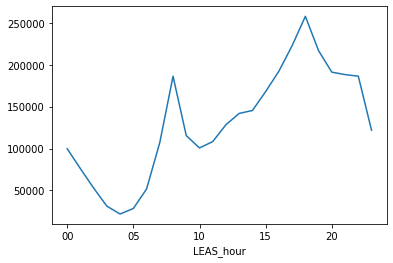

In [ ]:
#대여시간을 기준으로 groupby한 후 count
bicycle_LEAS.groupby('LEAS_hour')['LEAS_STATION'].count().plot()

### (2) 반납 자전거 스테이션 현황

In [ ]:
# 반납도 대여와 동일한 방식으로 시간대별 스테이션 이용현황 확인
bicycle_RTN['tempDATE']=bicycle_RTN.RTN_DATE.apply(lambda x:x.split())

# 시간 대 확인
bicycle_RTN['RTN_hour']=bicycle_RTN.tempDATE.apply(lambda x:x[1].split(":")[0])

bicycle_RTN.head(3)

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,RTN_DATE,RTN_STATION,tempDATE,RTN_hour
0,2017-01-01 00:13:52,260,"[2017-01-01, 00:13:52]",00
1,2017-01-01 00:50:24,231,"[2017-01-01, 00:50:24]",00
2,2017-01-01 01:01:50,0,"[2017-01-01, 01:01:50]",01


/opt/app-root/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='RTN_hour'>

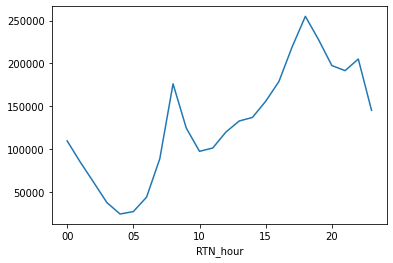

In [ ]:
# 시간(컬럼[RTN_hour]) 0-23으로 분리
# 시간대 별로 방문하는 스테이션 갯수 카운트
# 반납시간이 많은 시간대에 자전거 스테이션이 어떻게 분포하는가 확인
# 시각화

bicycle_RTN.groupby('RTN_hour')['RTN_STATION']
bicycle_RTN.groupby('RTN_hour')['RTN_STATION'].count().plot()

### - 시간대별로 대여/반납 빈도 추이가 유사

## 2) 대여 시간대를 기준으로 출근/퇴근/점심/막차 이후 사용빈도 분석

In [ ]:
# biclcye_now에 새로운 칼럼['tempDATE'] 추가
# 시간 값만 모아 ['LEAS_hour']에 추가
bicycle_now['tempDATE']=bicycle_now.LEAS_DATE.apply(lambda x: x.split())
bicycle_now['LEAS_hour']=bicycle_now.tempDATE.apply(lambda x:x[1].split(":")[0])

In [ ]:
#출근 시간 별 시리즈 생성
chulgeun07=bicycle_now['LEAS_hour']=='07'
chulgeun08=bicycle_now['LEAS_hour']=='08'
chulgeun09=bicycle_now['LEAS_hour']=='09'

In [ ]:
# 해당 시리즈를 bicycle_now의 칼럼으로 추가
chulgeun07=bicycle_now[chulgeun07]
chulgeun08=bicycle_now[chulgeun08]
chulgeun09=bicycle_now[chulgeun09]

In [ ]:
# 해당 시리즈를 bicycle_now의 칼럼으로 추가
bicycle_chulgeun=chulgeun07.append([chulgeun08, chulgeun09])
bicycle_chulgeun.head(3)

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS,tempDATE,LEAS_hour
325,15946095,2,2017-01-01 07:02:56,217,16,2017-01-01 07:10:24,207,20,0.0,12,162376,0.0,1A84400000F363,NaN,"[2017-01-01, 07:02:56]",07
326,15946097,2,2017-01-01 07:06:53,203,20,2017-01-01 07:52:56,203,20,0.0,1,187752,0.0,1A84400000F54F,NaN,"[2017-01-01, 07:06:53]",07
327,15946098,2,2017-01-01 07:08:26,203,14,2017-01-01 07:52:58,203,14,0.0,99,0,3185290.0,1A84400000F545,NaN,"[2017-01-01, 07:08:26]",07


## 출근 시간 자전거 스테이션 현황

In [ ]:
# 대여-반납 현황이 시간대별로 유사하기 때문에 대여 관련 자료만 추출한다.

bicycle_chulgeun_LEAS=bicycle_chulgeun[['LEAS_NO', 'LEAS_DATE', 'LEAS_STATION', 'LEAS_DEF_NO']]
bicycle_chulgeun_LEAS

,LEAS_NO,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO
325,15946095,2017-01-01 07:02:56,217,16
326,15946097,2017-01-01 07:06:53,203,20
327,15946098,2017-01-01 07:08:26,203,14
328,15946099,2017-01-01 07:13:04,328,15
329,15946100,2017-01-01 07:14:31,311,15
...,...,...,...,...
3141926,21716849,2019-12-31 09:53:13,319,15
3141927,21716851,2019-12-31 09:54:08,252,20
3141928,21716859,2019-12-31 09:55:53,253,21
3141929,21716864,2019-12-31 09:57:42,320,17


In [ ]:
# 결측값 확인
bicycle_chulgeun_LEAS.isnull().sum()

LEAS_NO         0
LEAS_DATE       0
LEAS_STATION    0
LEAS_DEF_NO     0
dtype: int64

In [ ]:
#LEAS_STATION의 대여 횟수
LEAS_counts1=bicycle_chulgeun_LEAS['LEAS_STATION'].value_counts()

In [ ]:
# 막차 시간대 대여횟수를 하나의 데이터 프레임으로 변형

hour_07to09 = LEAS_counts1.rename_axis('LEAS_STATION').reset_index(name='counts')
hour_07to09

,LEAS_STATION,counts
0,321,9261
1,311,8060
2,245,7912
3,343,7724
4,229,7569
...,...,...
150,171,185
151,265,166
152,264,134
153,351,73


In [ ]:
# 결측값 확인
bicycle_chulgeun_LEAS.isnull().sum()

LEAS_NO         0
LEAS_DATE       0
LEAS_STATION    0
LEAS_DEF_NO     0
dtype: int64

In [ ]:
#LEAS_STATION의 대여 횟수
LEAS_counts=bicycle_chulgeun_LEAS['LEAS_STATION'].value_counts()

In [ ]:
hour_07to09 = LEAS_counts.rename_axis('LEAS_STATION').reset_index(name='counts')
hour_07to09

,LEAS_STATION,counts
0,210,15446
1,260,6489
2,259,5992
3,306,5298
4,342,4951
...,...,...
151,351,37
152,256,37
153,992,33
154,263,16


In [ ]:
# 해당 스테이션별 위도 경도 입히기

bicycle_station=pd.read_csv(input_path.joinpath('02.자전거스테이션.csv'))

In [ ]:
hour_07to09['위도']=0
hour_07to09['경도']=0

for i in range(len(hour_07to09['LEAS_STATION'])):
    for j in range(len(bicycle_station['Station_ID'])):
        if hour_07to09['LEAS_STATION'].iloc[i]==bicycle_station['Station_ID'].iloc[j]:
            hour_07to09['위도'].iloc[i]=bicycle_station['위도'].iloc[j]
            hour_07to09['경도'].iloc[i]=bicycle_station['경도'].iloc[j]

/opt/app-root/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
hour_07to09.head()

,LEAS_STATION,counts,위도,경도
0,321,9261,37.681812,126.769340
1,311,8060,37.670203,126.768394
2,245,7912,37.675567,126.784853
3,343,7724,37.675036,126.768351
4,229,7569,37.672328,126.785754


In [ ]:
#점심 시간 별 시리즈 생성

lunch12=bicycle_now['LEAS_hour']=='12'
lunch13=bicycle_now['LEAS_hour']=='13'
lunch14=bicycle_now['LEAS_hour']=='14'

In [ ]:
#해당 시리즈를 bicycle_now의 칼럼으로 추가
lunch12=bicycle_now[lunch12]
lunch13=bicycle_now[lunch13]
lunch14=bicycle_now[lunch14]

In [ ]:
#해당 시리즈를 bicycle_now의 칼럼으로 추가
bicycle_lunch=lunch12.append([lunch13, lunch14])
bicycle_lunch.head(3)

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS,tempDATE,LEAS_hour
524,15946641,2,2017-01-01 12:00:18,309,30,2017-01-01 12:08:14,0,0,NaN,12,88663,0.0,1A84400000F2E7,1.0,"[2017-01-01, 12:00:18]",12
525,15946642,2,2017-01-01 12:00:50,253,5,2017-01-01 12:44:42,254,20,0.0,99,0,3185350.0,1A84400000099B,NaN,"[2017-01-01, 12:00:50]",12
526,15946643,2,2017-01-01 12:03:35,254,14,2017-01-01 12:53:01,254,19,0.0,99,0,3185352.0,1A84400000F368,NaN,"[2017-01-01, 12:03:35]",12


In [ ]:
# 점심시간대 자전거 스테이션 현황
bicycle_lunch_LEAS=bicycle_lunch[['LEAS_NO', 'LEAS_DATE', 'LEAS_STATION', 'LEAS_DEF_NO']]
bicycle_lunch_LEAS

,LEAS_NO,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO
524,15946641,2017-01-01 12:00:18,309,30
525,15946642,2017-01-01 12:00:50,253,5
526,15946643,2017-01-01 12:03:35,254,14
527,15946644,2017-01-01 12:03:52,250,28
528,15946645,2017-01-01 12:05:48,254,12
...,...,...,...,...
3142141,21717624,2019-12-31 14:54:26,318,10
3142142,21717629,2019-12-31 14:56:55,345,19
3142143,21717633,2019-12-31 14:58:43,212,5
3142144,21717634,2019-12-31 14:58:55,212,22


In [ ]:
#결측값 확인
bicycle_lunch_LEAS.isnull().sum()

LEAS_NO         0
LEAS_DATE       0
LEAS_STATION    0
LEAS_DEF_NO     0
dtype: int64

In [ ]:
#LEAS_STATION의 대여 횟수
LEAS_counts2= bicycle_lunch_LEAS['LEAS_STATION'].value_counts()

In [ ]:
# 점심시간대 대여 횟수를 하나의 데이터 프레임으로 변형
hour_12to14=LEAS_counts2.rename_axis('LEAS_STATION').reset_index(name='counts')
hour_12to14

,LEAS_STATION,counts
0,254,12419
1,253,12399
2,309,11303
3,259,9906
4,310,9608
...,...,...
150,992,175
151,265,161
152,264,97
153,351,73


In [ ]:
hour_12to14['위도']=0
hour_12to14['경도']=0

for i in range(len(hour_12to14['LEAS_STATION'])):
    for j in range(len(bicycle_station['Station_ID'])):
        if hour_12to14['LEAS_STATION'].iloc[i]==bicycle_station['Station_ID'].iloc[j]:
            hour_12to14['위도'].iloc[i]=bicycle_station['위도'].iloc[j]
            hour_12to14['경도'].iloc[i]=bicycle_station['경도'].iloc[j]

/opt/app-root/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
hour_12to14.head()

,LEAS_STATION,counts,위도,경도
0,254,12419,37.655647,126.768352
1,253,12399,37.663241,126.762162
2,309,11303,37.671278,126.761898
3,259,9906,37.656722,126.771620
4,310,9608,37.669687,126.761237


In [ ]:
# 퇴근 시간 별 시리즈 생성
toegeun16=bicycle_now['LEAS_hour']=='16'
toegeun17=bicycle_now['LEAS_hour']=='17'
toegeun18=bicycle_now['LEAS_hour']=='18'
toegeun19=bicycle_now['LEAS_hour']=='19'

In [ ]:
# 해당 시리즈를 bicycle_now의 칼럼으로 추가
toegeun16=bicycle_now[toegeun16]
toegeun17=bicycle_now[toegeun17]
toegeun18=bicycle_now[toegeun18]
toegeun19=bicycle_now[toegeun19]

In [ ]:
bicycle_toegeun=toegeun16.append([toegeun17, toegeun18, toegeun19])
bicycle_toegeun

,LEAS_NO,LEAS_STAT,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO,RTN_DATE,RTN_STATION,RTN_DEF_NO,TRNV_QTY,MEMB_DIV,MEMB_NO,TEMP_MEMB_NO,BIKE_TAG,RTN_PROCESS,tempDATE,LEAS_hour
876,15947200,2,2017-01-01 16:01:24,308,2,2017-01-01 16:16:49,330,2,21559.0,3,187628,0.0,1A8440000009B3,NaN,"[2017-01-01, 16:01:24]",16
877,15947203,2,2017-01-01 16:02:04,308,9,2017-01-01 16:28:30,330,7,23988.0,2,187831,0.0,1A84400000F50F,NaN,"[2017-01-01, 16:02:04]",16
878,15947204,2,2017-01-01 16:02:53,104,1,2017-01-01 16:15:14,330,16,9190.0,99,0,3185522.0,1A844000000092,NaN,"[2017-01-01, 16:02:53]",16
879,15947205,2,2017-01-01 16:03:01,257,35,2017-01-01 16:44:13,207,5,0.0,3,187041,0.0,1A8440000002F8,NaN,"[2017-01-01, 16:03:01]",16
880,15947206,2,2017-01-01 16:03:33,252,20,2017-01-01 16:49:24,252,20,0.0,99,0,3185523.0,1A844000000382,NaN,"[2017-01-01, 16:03:33]",16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142517,21718287,2,2019-12-31 19:53:30,203,17,2019-12-31 19:55:46,202,7,0.0,3,89273,0.0,1A84400000FDC4,NaN,"[2019-12-31, 19:53:30]",19
3142518,21718289,2,2019-12-31 19:54:22,248,2,2019-12-31 20:19:04,330,14,0.0,3,229913,0.0,1A84400000FC95,NaN,"[2019-12-31, 19:54:22]",19
3142519,21718291,2,2019-12-31 19:54:47,321,21,2019-12-31 20:50:17,0,0,NaN,36,180156,0.0,1A84400000F6A8,1.0,"[2019-12-31, 19:54:47]",19
3142520,21718295,2,2019-12-31 19:55:41,215,8,2019-12-31 20:08:35,231,16,0.0,12,170365,0.0,1A84400000FD10,NaN,"[2019-12-31, 19:55:41]",19


In [ ]:
## 퇴근 시간 대 자전거 스테이션 현황
bicycle_toegeun_LEAS=bicycle_toegeun[['LEAS_NO', 'LEAS_DATE', 'LEAS_STATION', 'LEAS_DEF_NO']]
bicycle_toegeun_LEAS

,LEAS_NO,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO
876,15947200,2017-01-01 16:01:24,308,2
877,15947203,2017-01-01 16:02:04,308,9
878,15947204,2017-01-01 16:02:53,104,1
879,15947205,2017-01-01 16:03:01,257,35
880,15947206,2017-01-01 16:03:33,252,20
...,...,...,...,...
3142517,21718287,2019-12-31 19:53:30,203,17
3142518,21718289,2019-12-31 19:54:22,248,2
3142519,21718291,2019-12-31 19:54:47,321,21
3142520,21718295,2019-12-31 19:55:41,215,8


In [ ]:
#결측값 확인
bicycle_toegeun_LEAS.isnull().sum()

LEAS_NO         0
LEAS_DATE       0
LEAS_STATION    0
LEAS_DEF_NO     0
dtype: int64

In [ ]:
#LEAS_STATION의 대여횟수
LEAS_counts3=bicycle_toegeun_LEAS['LEAS_STATION'].value_counts()

In [ ]:
# 퇴근 시간대 대여횟수를 하나의 데이터 프레임으로 변형
hour_16to19=LEAS_counts3.rename_axis('LEAS_STATION').reset_index(name='counts')
hour_16to19

,LEAS_STATION,counts
0,254,29333
1,253,26986
2,309,25843
3,259,25659
4,310,22368
...,...,...
151,264,147
152,265,130
153,351,116
154,263,46


In [ ]:
hour_16to19['위도']=0
hour_16to19['경도']=0

for i in range(len(hour_16to19['LEAS_STATION'])):
    for j in range(len(bicycle_station['Station_ID'])):
        if hour_16to19['LEAS_STATION'].iloc[i]==bicycle_station['Station_ID'].iloc[j]:
            hour_16to19['위도'].iloc[i]=bicycle_station['위도'].iloc[j]
            hour_16to19['경도'].iloc[i]=bicycle_station['경도'].iloc[j]

/opt/app-root/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
hour_16to19.head()

,LEAS_STATION,counts,위도,경도
0,254,29333,37.655647,126.768352
1,253,26986,37.663241,126.762162
2,309,25843,37.671278,126.761898
3,259,25659,37.656722,126.771620
4,310,22368,37.669687,126.761237


## 막차 시간 이후 자전거 스테이션 현황

In [ ]:
bicycle_makcha_LEAS=bicycle_makcha[['LEAS_NO', 'LEAS_DATE', 'LEAS_STATION', 'LEAS_DEF_NO']]
bicycle_makcha_LEAS

,LEAS_NO,LEAS_DATE,LEAS_STATION,LEAS_DEF_NO
0,15945541,2017-01-01 00:00:41,213,18
1,15945542,2017-01-01 00:01:03,231,4
2,15945543,2017-01-01 00:01:50,119,14
3,15945544,2017-01-01 00:02:09,121,17
4,15945545,2017-01-01 00:03:32,320,29
...,...,...,...,...
3141701,21716337,2019-12-31 03:12:34,307,13
3141702,21716339,2019-12-31 03:16:21,238,2
3141703,21716342,2019-12-31 03:22:43,210,10
3141704,21716346,2019-12-31 03:28:54,306,14


In [ ]:
# 결측값 확인
bicycle_makcha_LEAS.isnull().sum()

LEAS_NO         0
LEAS_DATE       0
LEAS_STATION    0
LEAS_DEF_NO     0
dtype: int64

In [ ]:
#LEAS_STATION의 대여 횟수
LEAS_counts=bicycle_makcha_LEAS['LEAS_STATION'].value_counts()

In [ ]:
# 막차 시간대 대여횟수를 하나의 데이터프레임으로 변형
hour_0to3 = LEAS_counts.rename_axis('LEAS_STATION').reset_index(name='counts')
hour_0to3

,LEAS_STATION,counts
0,210,15446
1,260,6489
2,259,5992
3,306,5298
4,342,4951
...,...,...
151,351,37
152,256,37
153,992,33
154,263,16


In [ ]:
hour_0to3['위도']=0
hour_0to3['경도']=0

for i in range(len(hour_0to3['LEAS_STATION'])):
    for j in range(len(bicycle_station['Station_ID'])):
        if hour_0to3['LEAS_STATION'].iloc[i]==bicycle_station['Station_ID'].iloc[j]:
            hour_0to3['위도'].iloc[i]=bicycle_station['위도'].iloc[j]
            hour_0to3['경도'].iloc[i]=bicycle_station['경도'].iloc[j]

/opt/app-root/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
hour_0to3.head()

,LEAS_STATION,counts,위도,경도
0,210,15446,37.663673,126.767099
1,260,6489,37.662030,126.768952
2,259,5992,37.656722,126.771620
3,306,5298,37.675838,126.747974
4,342,4951,37.677995,126.766402


## 3)사용빈도에 따른 자전거 스테이션별 위치

In [ ]:
station_info=pd.read_csv(input_path.joinpath('02.자전거스테이션.csv'))

In [ ]:
#bicycle_now에서 대여/반납 정류소만 추출
bicycle=bicycle_now[["LEAS_STATION", "RTN_STATION"]]

In [ ]:
# 대여와 반납을 따로 나누어 추출함
bicycle_leas = pd.DataFrame(bicycle_now["LEAS_STATION"])    # 대여 정류소만 뽑음
bicycle_rtn = pd.DataFrame(bicycle_now["RTN_STATION"])       # 반납 정류소만 뽑음

bicycle_leas['X'] = 0
bicycle_leas['Y'] = 0
bicycle_leas['count'] = 1

In [ ]:
# 대여한 정류소들 위치 채우기
bicycle_leas = bicycle_leas.groupby(by = ['LEAS_STATION']).sum()

bicycle_leas.reset_index()

bicycle_leas = bicycle_leas.reset_index().rename(columns={"index": "LEAS_STATION"})

for i in range(len(bicycle_leas['LEAS_STATION'])):
    for j in range(len(station_info['Station_ID'])):
        if bicycle_leas['LEAS_STATION'].iloc[i] == station_info['Station_ID'].iloc[j] :
            bicycle_leas['X'].iloc[i] = station_info['위도'].iloc[j]
            bicycle_leas['Y'].iloc[i] = station_info['경도'].iloc[j]
            break

/opt/app-root/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
bicycle_leas = bicycle_leas.sort_values(by ='count', ascending=False)

bicycle_leas = bicycle_leas.reset_index()

del bicycle_leas['index']
bicycle_leas

,LEAS_STATION,X,Y,count
0,253,37.663241,126.762162,83134
1,254,37.655647,126.768352,78594
2,309,37.671278,126.761898,78272
3,259,37.656722,126.771620,70746
4,210,37.663673,126.767099,69549
...,...,...,...,...
151,265,37.661296,126.750847,767
152,264,37.664403,126.748019,688
153,351,37.702259,126.767231,473
154,263,37.661579,126.747736,253


In [ ]:
# 완료된 파일을 csv로 저장하기
# 모든 csv파일은 QGIS로 시각화할 것
bicycle_leas.to_csv('bicycle_leas.csv',mode='w')

bicycle_rtn.to_csv('bicycle_rtn.csv',mode='w')

In [ ]:
# groupby와 count로 스테이션별로 총 대여가 얼마나 이루어졌는지 보기
a_leas = bicycle_leas.groupby(by='LEAS_STATION').count()
b_leas = a_leas.sort_values(by='X',ascending=False)

In [ ]:
# 집계된 자료 살펴보기 = 대여수가 높은 10개 스테이션
b_leas.head(10)

,X,Y,count
LEAS_STATION,,,
101,1,1,1
263,1,1,1
256,1,1,1
257,1,1,1
258,1,1,1
259,1,1,1
260,1,1,1
261,1,1,1
262,1,1,1


In [ ]:
# 집계된 자료 살펴보기 - 대여수가 낮은 10개 스테이션
b_leas.tail(10)

,X,Y,count
LEAS_STATION,,,
173,1,1,1
176,1,1,1
177,1,1,1
178,1,1,1
201,1,1,1
202,1,1,1
203,1,1,1
204,1,1,1
205,1,1,1


In [ ]:
# 불필요한 칼럼 삭제, 이름 재설정
del b_leas['X']
b_leas = b_leas.rename(columns = {"Y":"정류장 이용 건수"})

In [ ]:
b_leas

,정류장 이용 건수,count
LEAS_STATION,,
101,1,1
263,1,1
256,1,1
257,1,1
258,1,1
...,...,...
202,1,1
203,1,1
204,1,1


## 대여가 많은/적은 TOP10, TOP20 자전거 스테이션 정보 추출

In [ ]:
# 대여 많은 순 TOP10 뽑아 csv파일로 저장하기
s_1= b_leas.head(10)
s_1.to_csv('top_leas_1.csv',mode='w')

In [ ]:
# 대여 많은 순 TOP20 뽑아 csv파일로 저장하기
s_2 = b_leas.head(20)
s_2.to_csv('top_leas_2.csv',mode='w')

In [ ]:
# 대여 적은 순 TOP10 뽑아 csv파일로 저장하기
s_tail_1= b_leas.tail(10)
s_tail_1.to_csv('low_leas_1.csv',mode='w')

# 대여 적은 순 TOP20 뽑아 csv파일로 저장하기
s_tail_2 = b_leas.tail(20)
s_tail_2.to_csv('low_leas_2.csv',mode='w')

In [ ]:
# 반납
bicycle_rtn['X'] = 0
bicycle_rtn['Y'] = 0
bicycle_rtn['count'] = 1

In [ ]:
bicycle_rtn = bicycle_rtn.groupby(by = ['RTN_STATION']).sum()

bicycle_rtn.reset_index()

bicycle_rtn = bicycle_rtn.reset_index().rename(columns={"index": "RTN_STATION"})

for i in range(len(bicycle_rtn['RTN_STATION'])):
    for j in range(len(station_info['Station_ID'])):
        if bicycle_rtn['RTN_STATION'].iloc[i] == station_info['Station_ID'].iloc[j] :
            bicycle_rtn['X'].iloc[i] = station_info['위도'].iloc[j]
            bicycle_rtn['Y'].iloc[i] = station_info['경도'].iloc[j]
            break
bicycle_rtn = bicycle_rtn.sort_values(by ='count', ascending=False)

bicycle_rtn = bicycle_rtn.reset_index()

del bicycle_rtn['index']
bicycle_rtn

/opt/app-root/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,RTN_STATION,X,Y,count
0,0,0.000000,0.000000,398234
1,253,37.663241,126.762162,83718
2,254,37.655647,126.768352,81279
3,309,37.671278,126.761898,75719
4,210,37.663673,126.767099,72191
...,...,...,...,...
153,264,37.664403,126.748019,759
154,263,37.661579,126.747736,425
155,351,37.702259,126.767231,406
156,998,0.000000,0.000000,21


In [ ]:
# 반납 관련 데이터도 csv로 저장
# QGIS로 시각화할 것

bicycle_rtn.to_csv('bicycle_rtn.csv',mode='w')

In [ ]:
#RTN으로 파일만들기 - b_leas와 같은 작업
a_rtn = bicycle_rtn.groupby(by='RTN_STATION').count()

# 많은 순으로 뽑음
b_rtn = a_rtn.sort_values(by='X',ascending=False)
del b_rtn['X']
b_rtn = b_rtn.rename(columns = {"Y":"정류장 이용 건수"})

In [ ]:
# 대여가 많은 순으로 정류장 number를 뽑은 데이터
b_leas 

,X,Y,count
LEAS_STATION,,,
101,1,1,1
263,1,1,1
256,1,1,1
257,1,1,1
258,1,1,1
...,...,...,...
202,1,1,1
203,1,1,1
204,1,1,1


In [ ]:
# 반납이 많은 순으로 정류장 number를 뽑은 데이터
b_rtn

,정류장 이용 건수,count
RTN_STATION,,
0,1,1
263,1,1
256,1,1
257,1,1
258,1,1
...,...,...
202,1,1
203,1,1
204,1,1


### 반납이 많은/적은 TOP10, TOP20 자전거 스테이션 정보 추출

In [ ]:
# 반납 많은 순 TOP10 뽑아 csv파일로 저장하기
a_1 = b_rtn.head(10)
a_1.to_csv('top_rtn_1.csv',mode='w')

In [ ]:
# 반납 많은 순 TOP20 뽑아 csv파일로 저장하기
a_2 = b_rtn.head(20)
a_2.to_csv('top_rtn_2.csv',mode='w')

In [ ]:
# 2. 고양시 거주 인구 데이터 분석
## 1) 지하철
## 2) 버스

# 지하철 데이터를 기반으로 지하철역별 유동인구 데이터 추출하기

In [ ]:
import pandas as pd
import pathlib

import numpy as np

from tqdm.notebook import tqdm


from geoband import API

In [ ]:
# 파일 불러오기
input_path = pathlib.Path('./input')
if not input_path.is_dir():
    input_path.mkdir()    
        
API.GetCompasData('SBJ_2007_001', '1', input_path.joinpath('01.운영이력.csv'))
API.GetCompasData('SBJ_2007_001', '2', input_path.joinpath('02.자전거스테이션.csv'))
API.GetCompasData('SBJ_2007_001', '19',input_path.joinpath('19.전철역_공간정보.csv'))
API.GetCompasData('SBJ_2007_001', '29',input_path.joinpath('29.지하철 역별 이용객수.csv'))
API.GetCompasData('SBJ_2007_001', '20', input_path.joinpath('20.고양시_버스정류소.csv'))
API.GetCompasData('SBJ_2007_001', '21', input_path.joinpath('21.버스_정류장별_승하차_정보.csv'))


bicycle=pd.read_csv(input_path.joinpath('01.운영이력.csv'))
station_info = pd.read_csv(input_path.joinpath('02.자전거스테이션.csv'))
station_location = pd.read_csv(input_path.joinpath("19.전철역_공간정보.csv"))
station_data = pd.read_csv(input_path.joinpath("29.지하철 역별 이용객수.csv"))

/opt/app-root/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 코드 설명
## - 19. 전철역_공간정보
- rail_nm    해당 역의 호선 명입니다.
- station_nm    역 명입니다.
- lot_num_addr    해당 역의 지번 주소입니다.
- road_nm_addr    해당 역의 도로명 주소입니다.
- X    지하철역의 위도 입니다.
- Y    지하철역의 경도 입니다.

## 29. 지하철 역별 이용객수
- 호선명    해당 역의 호선 명입니다.
-  역명    역 명입니다.
- 행정구역    해당 역의 행정구역(동) 입니다.
- 년월구분    해당 라인 데이터의 년월구분 입니다.
- 승하차구분    해당 라인 데이터의 승하차구분 입니다.
- 월요일_합계    해당 역의 승하차 구분별 월요일 합계입니다.
- 화요일_합계    해당 역의 승하차 구분별 화요일 합계입니다.
- 수요일_합계    해당 역의 승하차 구분별 수요일 합계입니다.
- 목요일_합계    해당 역의 승하차 구분별 목요일 합계입니다.
- 금요일_합계    해당 역의 승하차 구분별 금요일 합계입니다.
- 토요일_합계    해당 역의 승하차 구분별 토요일 합계입니다.
- 일요일_합계    해당 역의 승하차 구분별 일요일 합계입니다.
- 모든요일_합계    해당 역의 승하차 구분별 모든요일 합계입니다.
- 월요일_평균    해당 역의 승하차 구분별 월요일 평균입니다.
- 화요일_평균    해당 역의 승하차 구분별 화요일 평균입니다.
- 수요일_평균    해당 역의 승하차 구분별 수요일 평균입니다.
- 목요일_평균    해당 역의 승하차 구분별 목요일 평균입니다.
- 금요일_평균    해당 역의 승하차 구분별 금요일 평균입니다.
- 토요일_평균    해당 역의 승하차 구분별 토요일 평균입니다.
- 일요일_평균    해당 역의 승하차 구분별 일요일 평균입니다.
- 모든요일_평균    해당 역의 승하차 구분별 모든요일 평균입니다.

In [ ]:
station_data.columns

Index(['호선명', '역명', '행정구역', '년월구분', '승하차구분', '월요일_합계', '화요일_합계', '수요일_합계',
       '목요일_합계', '금요일_합계', '토요일_합계', '일요일_합계', '모든요일_합계', '월요일_평균', '화요일_평균',
       '수요일_평균', '목요일_평균', '금요일_평균', '토요일_평균', '일요일_평균', '모든요일_평균'],
      dtype='object')

 ### station_data 중에서 '총승하차' 부분이 역별 유동인구를 가늠하기에 적절하다고 판단하여 그 부분을 살펴봅니다.

In [ ]:
# 총승하차만 남김.
station_data = station_data[station_data['승하차구분'] == '총승하차']  

In [ ]:
# 인덱스 재설정
station_data = station_data.reset_index(drop=True)

In [ ]:
#알아보기 쉽게 나머지 불필요한 칼럼들은 제거합니다
station_list = ['호선명','역명','승하차구분','모든요일_합계']
station_data = station_data[station_list]
station_data

,호선명,역명,승하차구분,모든요일_합계
0,3호선,지축,총승하차,1012460
1,경의선,화전,총승하차,1799161
2,경의선,강매,총승하차,1859720
3,경의선,행신,총승하차,5568132
4,경의선,능곡,총승하차,2637855
5,경의선,곡산,총승하차,404413
6,경의선,백마,총승하차,4733842
7,경의선,풍산,총승하차,3577046
8,경의선,일산,총승하차,6808074
9,경의선,탄현,총승하차,5356327


In [ ]:
# station_data 파일에 각 역의 위치를 입히기 시작
station_location

,rail_nm,station_nm,lot_num_addr,road_nm_addr,X,Y
0,3호선,대곡,경기도 고양시 덕양구 대장동 420-1,경기도 고양시 덕양구 대주로107번길 71-81,126.809614,37.632306
1,3호선,대화,경기도 고양시 일산서구 대화동 2221,경기도 고양시 일산서구 중앙로 지하 1569,126.747206,37.675846
2,경의중앙,일산,경기도 고양시 일산서구 일산동 655-691,경기도 고양시 일산서구 경의로 672,126.770067,37.682007
3,3호선,백석,경기도 고양시 일산동구 백석동 1538,경기도 고양시 일산동구 중앙로 지하 1042,126.788148,37.642953
4,경의중앙,대곡,경기도 고양시 덕양구 대장동 420-1,경기도 고양시 덕양구 대주로 107번길 71-81,126.811047,37.631615
5,경의중앙,강매,경기도 고양시 덕양구 행신동 1115-1,경기도 고양시 덕양구 소원로 202,126.844436,37.612290
6,경의중앙,백마,경기도 고양시 일산동구 백석동 92,경기도 고양시 일산동구 경의로 318,126.794067,37.658431
7,경의중앙,능곡,경기도 고양시 덕양구 토당동 454-3,경기도 고양시 덕양구 토당로 35,126.820838,37.618765
8,경의중앙,풍산,경기도 고양시 일산동구 풍동 1042,경기도 고양시 일산동구 경의로 486,126.786528,37.671815
9,경의중앙,행신,경기도 고양시 덕양구 행신동 812,경기도 고양시 덕양구 소원로 114,126.834117,37.612170


In [ ]:
# 호선이 여러개가 지나는 경우, 중복된 값이 있을 수 있다. 
for i in range(len(station_data)) :
    for j in range(len(station_data)) :
        
        if i!=j and station_data['역명'].iloc[i] == station_data['역명'].iloc[j] :
            print(i, j)
            
station_data['모든요일_합계'].iloc[0] = station_data['모든요일_합계'].iloc[0] + station_data['모든요일_합계'].iloc[11]
            
# 지축역은 호선이 중복되어 여러 값이 있음. 따라서 중복값 제거.
station_data = station_data.drop(11)     # 여러번돌리지 않아야 함! 
station_data = station_data.reset_index(drop=True)
station_data

0 11
11 0


,호선명,역명,승하차구분,모든요일_합계
0,3호선,지축,총승하차,1182838
1,경의선,화전,총승하차,1799161
2,경의선,강매,총승하차,1859720
3,경의선,행신,총승하차,5568132
4,경의선,능곡,총승하차,2637855
5,경의선,곡산,총승하차,404413
6,경의선,백마,총승하차,4733842
7,경의선,풍산,총승하차,3577046
8,경의선,일산,총승하차,6808074
9,경의선,탄현,총승하차,5356327


In [ ]:
station_data['X'] = 0
station_data['Y'] = 0
station_data

,호선명,역명,승하차구분,모든요일_합계,X,Y
0,3호선,지축,총승하차,1182838,0,0
1,경의선,화전,총승하차,1799161,0,0
2,경의선,강매,총승하차,1859720,0,0
3,경의선,행신,총승하차,5568132,0,0
4,경의선,능곡,총승하차,2637855,0,0
5,경의선,곡산,총승하차,404413,0,0
6,경의선,백마,총승하차,4733842,0,0
7,경의선,풍산,총승하차,3577046,0,0
8,경의선,일산,총승하차,6808074,0,0
9,경의선,탄현,총승하차,5356327,0,0


In [ ]:
# 이제 위치를 입히기
for i in range(len(station_data['역명'])):
    for j in range(len(station_location['station_nm'])):
        if station_data['역명'].iloc[i] == station_location['station_nm'].iloc[j] :
            print(i, station_data['역명'].iloc[i], station_location['X'].iloc[j], station_location['Y'].iloc[j])
            station_data['X'].iloc[i] = station_location['X'].iloc[j]
            station_data['Y'].iloc[i] = station_location['Y'].iloc[j]
            break

for i in range(len(station_data)) :
    if station_data['X'].iloc[i] == 0 :
        print('위치정보 못 받은 역은 ', station_data['역명'].iloc[i])


for i in range(len(station_location)) :
    if '지축' in station_location['station_nm'].iloc[i] or '화전' in station_location['station_nm'].iloc[i] :
        print('station_location 파일에서 ',i, station_location['station_nm'].iloc[i])
        
        
        
        

station_data['X'].iloc[0] = station_location['X'].iloc[20]
station_data['Y'].iloc[0] = station_location['Y'].iloc[20]
     
station_data['X'].iloc[1] = station_location['X'].iloc[10]
station_data['Y'].iloc[1] = station_location['Y'].iloc[10]

station_data  # 이제 위치는 다 뽑고, 정렬만 다시 하면 된다

2 강매 126.84443637 37.61228963
3 행신 126.834117 37.61217
4 능곡 126.82083836 37.61876543
5 곡산 126.80151439 37.64612663
6 백마 126.794067 37.658431
7 풍산 126.786528 37.671815
8 일산 126.77006749 37.68200683
9 탄현 126.76116553 37.69385707
10 원흥 126.87260033 37.65074577
11 삼송 126.89558955 37.65310988
12 원당 126.84303034 37.65331645
13 화정 126.83266635 37.63459661
14 대곡 126.809614 37.632306
15 백석 126.7881483 37.64295283
16 마두 126.77764972 37.65217351
17 정발산 126.77335864 37.65949317
18 주엽 126.76122972 37.67014215
19 대화 126.747206 37.675846
위치정보 못 받은 역은  지축
위치정보 못 받은 역은  화전
station_location 파일에서  10 화전(한국항공대)
station_location 파일에서  20 지축역


/opt/app-root/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,호선명,역명,승하차구분,모든요일_합계,X,Y
0,3호선,지축,총승하차,1182838,126.913728,37.648118
1,경의선,화전,총승하차,1799161,126.867947,37.603298
2,경의선,강매,총승하차,1859720,126.844436,37.612290
3,경의선,행신,총승하차,5568132,126.834117,37.612170
4,경의선,능곡,총승하차,2637855,126.820838,37.618765
5,경의선,곡산,총승하차,404413,126.801514,37.646127
6,경의선,백마,총승하차,4733842,126.794067,37.658431
7,경의선,풍산,총승하차,3577046,126.786528,37.671815
8,경의선,일산,총승하차,6808074,126.770067,37.682007
9,경의선,탄현,총승하차,5356327,126.761166,37.693857


In [ ]:
# 사람들이 많이 다니는 순으로 정렬
station_data = station_data.sort_values(by='모든요일_합계',ascending=False)  
station_data

#다시 보기좋게 인덱스 정렬
station_data = station_data.reset_index(drop=True)   
station_data

# 저장해놓기
station_data1 = station_data.copy()   
station_data = station_data1

# 완료
station_data    


,호선명,역명,승하차구분,모든요일_합계,X,Y
0,일산선,화정,총승하차,14522105,126.832666,37.634597
1,일산선,삼송,총승하차,11526325,126.895590,37.653110
2,일산선,대화,총승하차,10008025,126.747206,37.675846
3,일산선,원당,총승하차,8607849,126.843030,37.653316
4,일산선,백석,총승하차,8533226,126.788148,37.642953
5,일산선,주엽,총승하차,7234466,126.761230,37.670142
6,일산선,정발산,총승하차,6843625,126.773359,37.659493
7,경의선,일산,총승하차,6808074,126.770067,37.682007
8,일산선,마두,총승하차,6222179,126.777650,37.652174
9,경원선,원흥,총승하차,5757420,126.872600,37.650746


# 버스데이터를 기반으로 인구유동성 데이터 추출하기 

## 데이터 설명 
 ### 20.고양시_버스정류소
- 현재 기준의 고양시 버스 정류소, 마을버스 정류소 위치 정보입니다.
- STATION_NM    버스정류장 명 입니다.
- STATION_ID    버스정류장 고유 ID 입니다.
- X    버스정류장의 위도 입니다.
- Y    버스정류장의 경도 입니다.

### 21.버스_정류장별_승하차_정보
- 최근 1년치 고양시 버스 정류장별 승하차 정보입니다.
- STATION_ID    버스정류장 고유 ID 입니다.
- STATION_NM    버스정류장 명 입니다.
- GETON_CNT    버스정류장 승차인원 수 입니다.

### 두 파일을 병합하기 
- STATION_ID: 정류장ID
- STATION_NM: 정류장 이름
- GETON_CNT: 승하차인원수
- X: 경도
- Y: 위도

In [ ]:
bustatonf = pd.read_csv(input_path.joinpath('20.고양시_버스정류소.csv'))
bustat = pd.read_csv(input_path.joinpath('21.버스_정류장별_승하차_정보.csv'))

In [ ]:
# merge 이용
bus = bustat.merge(bustatonf, on=['STATION_NM','STATION_ID'])
bus

#2823개

,STATION_ID,STATION_NM,GETON_CNT,X,Y
0,218001046,화정역3호선,229091,126.832410,37.635347
1,218001083,원당역,219186,126.843885,37.653079
2,218000974,화정역3호선,197084,126.832827,37.634486
3,218000974,화정역3호선,5335,126.832827,37.634486
4,219000193,대화역,191696,126.747539,37.676390
...,...,...,...,...,...
2818,219000882,환경사업소,0,126.726069,37.659134
2819,219000968,장항굴다리,0,126.761935,37.647081
2820,218000827,새벽교회,0,126.858807,37.721591
2821,218000888,남양유업,0,126.852764,37.666689


## groupby를 통해 동명의 정류장끼리 묶는다
 - 위치가 조금씩 다르지만 같은 한글이름을 사용하는 정류장들을 묶음

In [ ]:
bus_grouped = bus.groupby(['STATION_NM','STATION_ID','GETON_CNT'],as_index=False).sum()
bus_grouped

,STATION_NM,STATION_ID,GETON_CNT,X,Y
0,(구)효자동주민센터,218000258,149,126.919747,37.652634
1,(구)효자동주민센터,218000258,195,126.919747,37.652634
2,(구)효자동주민센터,218000265,19,126.919892,37.652603
3,(구)효자동주민센터,218000265,27,126.919892,37.652603
4,16단지.삼송초교,218001182,9686,126.882791,37.653627
...,...,...,...,...,...
2818,흰돌마을(중),219000453,6900,126.781373,37.648172
2819,흰돌마을(중),219000453,7817,126.781373,37.648172
2820,흰돌마을.서안아파트,219000161,934,126.785637,37.641313
2821,흰돌마을.서안아파트,219000161,10467,126.785637,37.641313


## 동명의 정류장 중 경위도값이 같은 정류장끼리는 GETON_CNT를 더해준다 (groupby)

In [ ]:
# 재정의
bus2 = bus_grouped

In [ ]:
# 위치가 같은 정류소 중복을 방지
bus3 = bus2.groupby(['STATION_NM','STATION_ID','X','Y'], as_index=False).sum()
bus3

,STATION_NM,STATION_ID,X,Y,GETON_CNT
0,(구)효자동주민센터,218000258,126.919747,37.652634,344
1,(구)효자동주민센터,218000265,126.919892,37.652603,46
2,16단지.삼송초교,218001182,126.882791,37.653627,9686
3,16단지.삼송초교,218001187,126.883295,37.653999,1126
4,1군단앞,218000498,126.911514,37.716309,21
...,...,...,...,...,...
2076,희망원,219000229,126.821292,37.702977,1248
2077,흰돌5단지.서안아파트,219000213,126.785729,37.640872,14603
2078,흰돌마을(중),219000453,126.781373,37.648172,14717
2079,흰돌마을.서안아파트,219000161,126.785637,37.641313,11401


In [ ]:
bus3.head(10)

,STATION_NM,STATION_ID,X,Y,GETON_CNT
0,(구)효자동주민센터,218000258,126.919747,37.652634,344
1,(구)효자동주민센터,218000265,126.919892,37.652603,46
2,16단지.삼송초교,218001182,126.882791,37.653627,9686
3,16단지.삼송초교,218001187,126.883295,37.653999,1126
4,1군단앞,218000498,126.911514,37.716309,21
5,1군단앞,218000500,126.912488,37.717179,321
6,2단지관리사무실앞,218000743,126.836772,37.646522,303
7,2단지라이프아파트앞,218000932,126.837170,37.645662,24
8,2단지라이프아파트앞,218001009,126.837020,37.645986,14376
9,5단지관리사무실앞,218000740,126.836483,37.642546,7119


## 상위 몇개만 뽑아보면 버스승하차 횟수가 많은 지역을 알 수 있을 것이다

In [ ]:
bus_a = bus3.sort_values(by='GETON_CNT', ascending=False)
bus_a

,STATION_NM,STATION_ID,X,Y,GETON_CNT
384,대화역,219000193,126.747539,37.676390,361686
2023,화정역3호선,218001046,126.832410,37.635347,229091
1340,원당역,218001083,126.843885,37.653079,219186
2022,화정역3호선,218000974,126.832827,37.634486,202419
385,대화역,219000366,126.747416,37.675989,199238
...,...,...,...,...,...
1325,원골마을회관,218000597,126.864203,37.581361,0
888,새벽교회,218000827,126.858807,37.721591,0
398,덕은동,218000594,126.860548,37.581514,0
56,가좌동성당,219001111,126.726562,37.697732,0


In [ ]:
# 전체 버스 정류장 평균 승하차인원이 4700여명 정도 된다
bus_a.describe() 

,STATION_ID,X,Y,GETON_CNT
count,2.081000e+03,2081.000000,2081.000000,2081.000000
mean,2.185258e+08,126.819148,37.666634,4688.834695
std,1.033896e+06,0.053995,0.032485,16699.517366
min,2.180000e+08,126.679997,37.581102,0.000000
25%,2.180008e+08,126.777363,37.644999,70.000000
50%,2.180013e+08,126.823145,37.668142,573.000000
75%,2.190006e+08,126.859858,37.691194,3677.000000
max,2.415011e+08,126.962809,37.747089,361686.000000


## 승하차별 상위 n개의 버스데이터를 만들어 살펴보자 
 - csv파일로 만들어 저장한 뒤, qgis프로그램을 이용하여 지도에 좌표를 찍는 시각화를 통해서 한 눈에 알아볼 수 있음

In [ ]:
# 이용이 많은 버스정류장 상위 30개를 살펴볼 수 있다
bus_a_top30 = bus_a.head(30)

# 이용이 많은 버스정류장 상위 50개를 살펴볼 수 있다
bus_a_top50 = bus_a.head(50)

# 이용이 많은 버스정류장 상위 100개를 살펴볼 수 있다
bus_a_top100 = bus_a.head(100)

In [ ]:
# csv파일로 만들어 추후 qgis 시각화에 이용
bus_a_top30.to_csv('bus_a_top30.csv')
bus_a_top50.to_csv('bus_a_top50.csv')
bus_a_top100.to_csv('bus_a_top100.csv')

In [ ]:
# 재정의
bus_a_top100 = bus_a_top100.copy()
bus_a_top100

,STATION_NM,STATION_ID,X,Y,GETON_CNT
384,대화역,219000193,126.747539,37.676390,361686
2023,화정역3호선,218001046,126.832410,37.635347,229091
1340,원당역,218001083,126.843885,37.653079,219186
2022,화정역3호선,218000974,126.832827,37.634486,202419
385,대화역,219000366,126.747416,37.675989,199238
...,...,...,...,...,...
899,샘터마을2단지.신능중학교,218000118,126.833738,37.621644,19139
1916,행신역,218001019,126.835049,37.612941,18961
1087,숲속마을4.5단지,219000460,126.800155,37.669089,18927
1745,탄현효성주은아파트,219000315,126.768340,37.690707,18923


- 중복되는 정류장 (= 상/하행이 있는 정류장)과 중복되지 않는 정류장 분류
- 중복되는 정류장 -> 어쨌든 양방향 유동인구가 많다는 것을 의미 -->  합쳐진 데이터로 분석

In [ ]:
# 여기서는 중복되지 않는 정류장 이름들을 살펴본다

bus_a_top100_no_dup = bus_a_top100.drop_duplicates(["STATION_NM"], keep=False)
bus_a_top100_no_dup.info()

# # 총59곳 --> 중복되는 것의 짝이 두개씩이면 중복되지 않는 것도 짝수 값이 나올텐데
# 홀수값 --> 정류장이름이 중복되는 것이 세개씩 있는 것도 있을 것이라고 추측가능함.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 1340 to 442
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STATION_NM  59 non-null     object 
 1   STATION_ID  59 non-null     int64  
 2   X           59 non-null     float64
 3   Y           59 non-null     float64
 4   GETON_CNT   59 non-null     int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 2.8+ KB


In [ ]:
# 중복되지 않는 정류장
bus_a_top100_no_dup

,STATION_NM,STATION_ID,X,Y,GETON_CNT
1340,원당역,218001083,126.843885,37.653079,219186
855,삼송역8번출구,218001200,126.896880,37.653835,102780
853,삼송역5번출구,218000284,126.893512,37.653499,82318
2020,화정역.롯데마트,218000019,126.830748,37.632918,66042
851,삼송역3번출구,218001280,126.895430,37.652687,58272
854,삼송역6번출구,218000627,126.896329,37.653501,55333
852,삼송역4번출구,218000090,126.893807,37.653250,55069
1367,원흥역3번출구,218000696,126.873272,37.650091,50388
2013,화정1동행정복지센터,218000102,126.834066,37.646016,46277
1947,현대백화점,219000625,126.752013,37.668475,46162


In [ ]:
# 중복되는 정류소 뽑기

bus_top_data = pd.concat([bus_a_top100, bus_a_top100_no_dup, bus_a_top100_no_dup]).drop_duplicates(keep=False)
bus_top_data

# "리스쇼핑.원당시장"은 값이 3개다
# 왜인가 했더니 (지역의 특성상) 로타리라서 정류장이 많음 (총 4개)
# 이 곳은 양방향 유동인구가 많다고 할 수 있겠다

,STATION_NM,STATION_ID,X,Y,GETON_CNT
384,대화역,219000193,126.747539,37.676390,361686
2023,화정역3호선,218001046,126.832410,37.635347,229091
2022,화정역3호선,218000974,126.832827,37.634486,202419
385,대화역,219000366,126.747416,37.675989,199238
534,마두역(중),219000370,126.777480,37.652390,162142
1478,일산동구청(중),219000356,126.774287,37.657816,156731
1590,주엽역(중),219000189,126.761634,37.670067,154395
1477,일산동구청(중),219000191,126.774728,37.657438,151423
535,마두역(중),219000383,126.778044,37.651717,148257
1591,주엽역(중),219000363,126.760893,37.670280,119326


In [ ]:
# 총41곳
bus_top_data['STATION_NM'].count()

41

In [ ]:
# 짝이 다 맞는지 확인하기. 완료
bus_top_data.groupby('STATION_NM').count()

,STATION_ID,X,Y,GETON_CNT
STATION_NM,,,,
강선마을(중),2,2,2,2
고양경찰서(중),2,2,2,2
고양동시장,2,2,2,2
관산동.벽제시장,2,2,2,2
대화역,2,2,2,2
리스쇼핑.원당시장,3,3,3,3
마두1동행정복지센터,2,2,2,2
마두역(중),2,2,2,2
문촌마을(중),2,2,2,2


# 3. 고양시 거주 인구
### 1) 최근 3개년(2017-2019) 고양시 인구 변화
### 2) 신규 택지 개발 지역(장항/송산/대화) 3개년 인구 변화
### 3) 인구 누적 분포

### 공공자전거와 대중교통 데이터 분석 결과
- 버스/지하철 역별 인구과밀집 지역 데이터로 특정 지역에 인구 과밀집
- 해당 과밀집 지역에서 점심/퇴근 시간에 공공 자전거 이용률 최다(주로 200번대 정류장)
- 출근 및 새벽 시간대는 300번대 자전거 정류장 사용(주거 밀집지역 인근)
- 두 시간 대 이용 정류장 차이를 위해 주거 지역 인구 및 인구 밀도 데이터 분석

In [ ]:
input_path = pathlib.Path('./input')
if not input_path.is_dir():
    input_path.mkdir()
    
API.GetCompasData('SBJ_2007_001', '6', input_path.joinpath('06.인구(거주)분포도(100M_X_100M).geojson'))
API.GetCompasData('SBJ_2007_001', '7', input_path.joinpath('07.인구통계.csv'))
API.GetCompasData('SBJ_2007_001', '8', input_path.joinpath('08.행정경계(시군구).geojson'))
API.GetCompasData('SBJ_2007_001', '34', input_path.joinpath('34.고양시_행정경계(행정동기준).geojson'))

for path in list(input_path.glob('*.csv')) + list(input_path.glob('*.geojson')):
    print(path)

input/01.운영이력.csv
input/02.자전거스테이션.csv
input/19.전철역_공간정보.csv
input/20.고양시 버스정류소.csv
input/07.인구통계.csv
input/운영이력.csv
input/자전거스테이션.csv
input/전철역_공간정보.csv
input/고양시 버스정류소.csv
input/29.지하철 역별 이용객수.csv
input/20.고양시_버스정류소.csv
input/21.버스_정류장별_승하차_정보.csv
input/17.일반건물 분포도(100M X 100M).geojson
input/15.도로명주소_건물.geojson
input/16.도로명주소_도로.geojson
input/06.인구(거주)분포도(100M_X_100M).geojson
input/일반건물 분포도(100M X 100M).geojson
input/도로명주소_건물.geojson
input/도로명주소_도로.geojson
input/34.고양시_행정경계(행정동기준).geojson
input/08.행정경계(시군구).geojson


# 1. 고양시 인구 변화
### 인구통계 변수
- 행정구역: 행정 구역 구분
- 조회기준: 조사한 연/월
- 총인구수: 총 인구 수
- 세대수: 세대 수
- 세대당 인구: 세대당 평균 인구
- 남자 인구수: 남자 총 인구 수
- 여자 인구수: 여자 총 인구 수
- 남여 비율: 남여 비율

In [ ]:
# 고양시 전체 인구 통계 데이터 확인
population = pd.read_csv('07.인구통계.csv') ; population

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
0,경기도 고양시 (4128000000),2017년01월,"1,040,648","402,440",2.59,"511,353","529,295",0.97
1,경기도 고양시 (4128000000),2017년02월,"1,040,483","403,042",2.58,"511,266","529,217",0.97
2,경기도 고양시 (4128000000),2017년03월,"1,040,482","403,443",2.58,"511,182","529,300",0.97
3,경기도 고양시 (4128000000),2017년04월,"1,040,608","403,933",2.58,"511,225","529,383",0.97
4,경기도 고양시 (4128000000),2017년05월,"1,040,892","404,603",2.57,"511,347","529,545",0.97
...,...,...,...,...,...,...,...,...
1579,경기도 고양시 일산서구 송산동(4128759000),2019년08월,"50,610","18,390",2.75,"24,983","25,627",0.97
1580,경기도 고양시 일산서구 송산동(4128759000),2019년09월,"50,694","18,404",2.75,"25,025","25,669",0.97
1581,경기도 고양시 일산서구 송산동(4128759000),2019년10월,"50,660","18,398",2.75,"25,020","25,640",0.98
1582,경기도 고양시 일산서구 송산동(4128759000),2019년11월,"50,865","18,480",2.75,"25,112","25,753",0.98


In [ ]:
# 고양시 전체 총 인구 변화 추이

population_all = population.loc[population['행정구역'].str.contains('4128000000', na=False)]
population_all

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
0,경기도 고양시 (4128000000),2017년01월,"1,040,648","402,440",2.59,"511,353","529,295",0.97
1,경기도 고양시 (4128000000),2017년02월,"1,040,483","403,042",2.58,"511,266","529,217",0.97
2,경기도 고양시 (4128000000),2017년03월,"1,040,482","403,443",2.58,"511,182","529,300",0.97
3,경기도 고양시 (4128000000),2017년04월,"1,040,608","403,933",2.58,"511,225","529,383",0.97
4,경기도 고양시 (4128000000),2017년05월,"1,040,892","404,603",2.57,"511,347","529,545",0.97
5,경기도 고양시 (4128000000),2017년06월,"1,041,375","405,641",2.57,"511,587","529,788",0.97
6,경기도 고양시 (4128000000),2017년07월,"1,041,587","406,314",2.56,"511,575","530,012",0.97
7,경기도 고양시 (4128000000),2017년08월,"1,041,507","406,768",2.56,"511,486","530,021",0.97
8,경기도 고양시 (4128000000),2017년09월,"1,041,399","407,272",2.56,"511,328","530,071",0.96
9,경기도 고양시 (4128000000),2017년10월,"1,041,706","407,871",2.55,"511,397","530,309",0.96


In [ ]:
# 인구 추이 변화를 보기 위해 시각화
# '총인구수'가 object이기에 float로 변환
# 빠른 계산을 위해 ','제거

population['총인구수']=population['총인구수'].str.replace(',','').astype(float)

/opt/app-root/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='조회기준'>

/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51312 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51456 missing from current

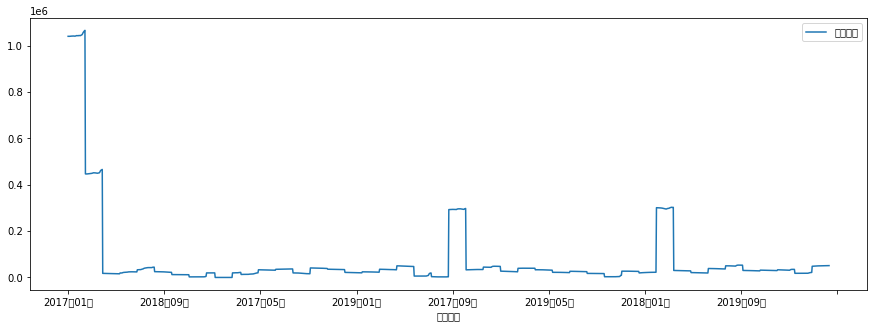

In [ ]:
population.plot(x='조회기준', y='총인구수', kind='line', figsize=(15,5))

# 2. 신규 택지 개발 지역(장항1동/송산동/대화동) 3개년 인구 변화

In [ ]:
# 송산동
population_song=population.loc[population['행정구역'].str.contains('송산', na=False)]
#na 파라미터의 역할 : 결측치 채우기

population_song

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
1548,경기도 고양시 일산서구 송산동(4128759000),2017년01월,48294.0,"16,855",2.87,"23,893","24,401",0.98
1549,경기도 고양시 일산서구 송산동(4128759000),2017년02월,48456.0,"16,938",2.86,"23,995","24,461",0.98
1550,경기도 고양시 일산서구 송산동(4128759000),2017년03월,48619.0,"17,002",2.86,"24,060","24,559",0.98
1551,경기도 고양시 일산서구 송산동(4128759000),2017년04월,48837.0,"17,080",2.86,"24,158","24,679",0.98
1552,경기도 고양시 일산서구 송산동(4128759000),2017년05월,48955.0,"17,146",2.86,"24,216","24,739",0.98
1553,경기도 고양시 일산서구 송산동(4128759000),2017년06월,49045.0,"17,198",2.85,"24,273","24,772",0.98
1554,경기도 고양시 일산서구 송산동(4128759000),2017년07월,49085.0,"17,216",2.85,"24,270","24,815",0.98
1555,경기도 고양시 일산서구 송산동(4128759000),2017년08월,49104.0,"17,221",2.85,"24,282","24,822",0.98
1556,경기도 고양시 일산서구 송산동(4128759000),2017년09월,49307.0,"17,310",2.85,"24,376","24,931",0.98
1557,경기도 고양시 일산서구 송산동(4128759000),2017년10월,49473.0,"17,407",2.84,"24,437","25,036",0.98


/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/app-root/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='조회기준'>

/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51312 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51456 missing from current

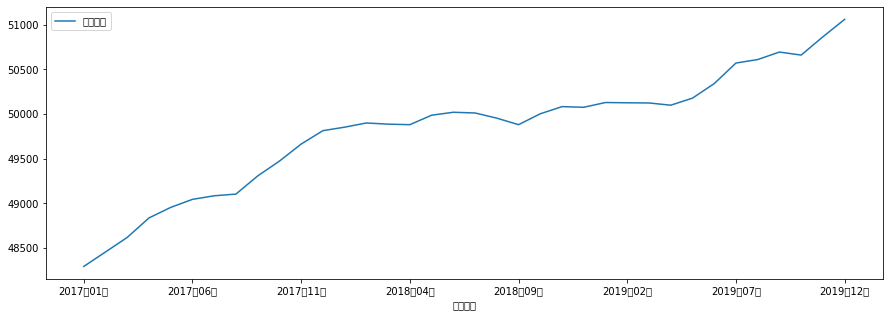

In [ ]:
# 송산동 인구 추이 변화를 보기 위해 시각화
# '총인구수'가 object이기에 int로 변환


population_song['총인구수']=population_song['총인구수'].astype(int)

# 송산 인구변화 추이
population_song.plot(x='조회기준', y='총인구수', kind='line', figsize=(15,5))

In [ ]:
# 대화동
population_dae=population.loc[population['행정구역'].str.contains('대화', na=False)]
population_dae

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
1476,경기도 고양시 일산서구 대화동(4128757000),2017년01월,33108.0,"13,781",2.40,"16,042","17,066",0.94
1477,경기도 고양시 일산서구 대화동(4128757000),2017년02월,33053.0,"13,767",2.40,"16,004","17,049",0.94
1478,경기도 고양시 일산서구 대화동(4128757000),2017년03월,33047.0,"13,790",2.40,"15,984","17,063",0.94
1479,경기도 고양시 일산서구 대화동(4128757000),2017년04월,32940.0,"13,745",2.40,"15,949","16,991",0.94
1480,경기도 고양시 일산서구 대화동(4128757000),2017년05월,32870.0,"13,742",2.39,"15,907","16,963",0.94
1481,경기도 고양시 일산서구 대화동(4128757000),2017년06월,32827.0,"13,800",2.38,"15,878","16,949",0.94
1482,경기도 고양시 일산서구 대화동(4128757000),2017년07월,32836.0,"13,829",2.37,"15,842","16,994",0.93
1483,경기도 고양시 일산서구 대화동(4128757000),2017년08월,32763.0,"13,807",2.37,"15,793","16,970",0.93
1484,경기도 고양시 일산서구 대화동(4128757000),2017년09월,32697.0,"13,793",2.37,"15,755","16,942",0.93
1485,경기도 고양시 일산서구 대화동(4128757000),2017년10월,32615.0,"13,793",2.36,"15,733","16,882",0.93


/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/app-root/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='조회기준'>

/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51312 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51456 missing from current

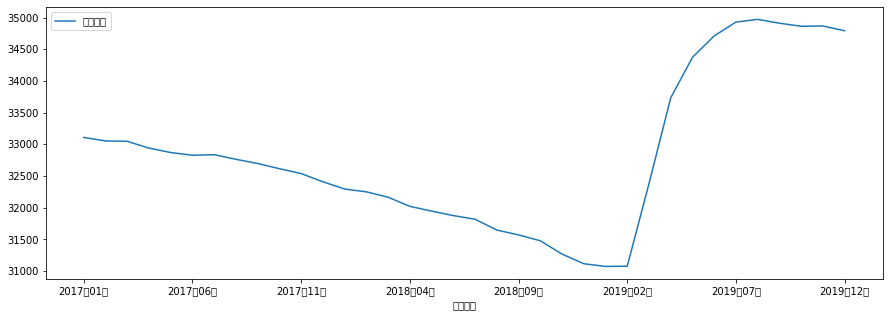

In [ ]:
# 데이터 타입 변경
population_dae['총인구수'] = population_dae['총인구수'].astype(int)
population_dae['총인구수'].head()

# 대화 인구변화 추이
population_dae.plot(x='조회기준', y='총인구수', kind='line', figsize=(15,5))

In [ ]:
# 장항동 1동
population_jang1 = population.loc[population['행정구역'].str.contains('장항1', na=False)]
population_jang1

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
1116,경기도 고양시 일산동구 장항1동(4128558000),2017년01월,3077.0,"1,611",1.91,"1,723","1,354",1.27
1117,경기도 고양시 일산동구 장항1동(4128558000),2017년02월,3067.0,"1,610",1.90,"1,719","1,348",1.28
1118,경기도 고양시 일산동구 장항1동(4128558000),2017년03월,3084.0,"1,620",1.90,"1,734","1,350",1.28
1119,경기도 고양시 일산동구 장항1동(4128558000),2017년04월,3078.0,"1,616",1.90,"1,729","1,349",1.28
1120,경기도 고양시 일산동구 장항1동(4128558000),2017년05월,3093.0,"1,622",1.91,"1,739","1,354",1.28
1121,경기도 고양시 일산동구 장항1동(4128558000),2017년06월,3099.0,"1,633",1.90,"1,750","1,349",1.30
1122,경기도 고양시 일산동구 장항1동(4128558000),2017년07월,3096.0,"1,635",1.89,"1,749","1,347",1.30
1123,경기도 고양시 일산동구 장항1동(4128558000),2017년08월,3079.0,"1,634",1.88,"1,746","1,333",1.31
1124,경기도 고양시 일산동구 장항1동(4128558000),2017년09월,3093.0,"1,639",1.89,"1,748","1,345",1.30
1125,경기도 고양시 일산동구 장항1동(4128558000),2017년10월,3108.0,"1,643",1.89,"1,754","1,354",1.30


In [ ]:
population_jang1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 1116 to 1151
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   행정구역    36 non-null     object 
 1   조회기준    36 non-null     object 
 2   총인구수    36 non-null     float64
 3   세대수     36 non-null     object 
 4   세대당 인구  36 non-null     float64
 5   남자 인구수  36 non-null     object 
 6   여자 인구수  36 non-null     object 
 7   남여 비율   36 non-null     float64
dtypes: float64(3), object(5)
memory usage: 2.5+ KB


In [ ]:
population_jang1_2 = population_jang1.copy()
population_jang1_2['총인구수']=population_jang1_2['총인구수'].astype(float)

/opt/app-root/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='조회기준'>

/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51312 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51456 missing from current

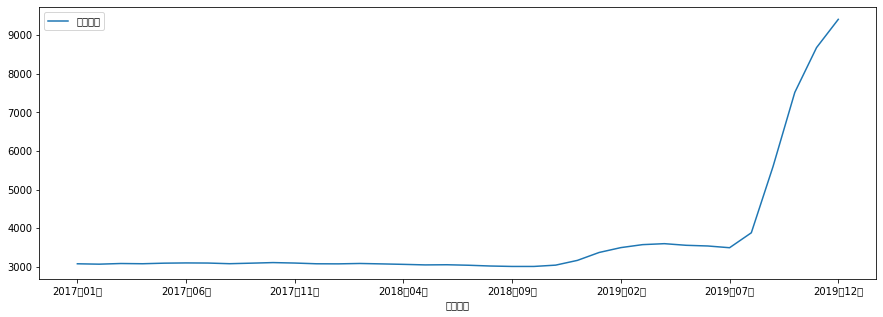

In [ ]:
population_jang1_2.plot(x='조회기준', y='총인구수', kind='line', figsize=(15,5))

## 인구 통계 분석 결과

1. 송산동은 2017년 1월 이후 꾸준한 인구 증가
2. 대화동은 인구 감소세에서 2019년 2월 기준 급격한 증가
3. 장항동은 2019년 들어 인구 유입 증가

### 분석결과를 통한 현재 결론
   1. 현재 자전거 스테이션은 유동인구가 많은 버스/지하철 정류장 인근 
        -> 현황 유지
   2. 막차 이후 사용량이 많지만 반납 장소가 거주지에서 멀리 떨어져 있어 반납의 어려움이 있음. 
        -> 막차 이후 대여량이 많아지는 정류장+ 반납량이 많은 스테이션 주변에 추가 설치
   3. 장항/송산/대화 지역 거주 인구 증가에 비례하지 못하는 자전거 스테이션 
        -> 장항/송산/대화 인구에 맞는 자전거 스테이션 위치 추가 확보
        
### 인구누적분포데이터 분석
- 장항/송산/대화 지역 인구 밀집 현황 확인
- 특히 킨텍스 신시가지 및 호수공원 일대 인구 변화 확인

In [ ]:
# 인구누적분포 데이터
# geopandas
pop_distribution = gpd.read_file('06.인구(거주)분포도(100M_X_100M).geojson')
pop_distribution

,gid,val,geometry
0,다사268650,NaN,"MULTIPOLYGON (((126.66985 37.68162, 126.66984 ..."
1,다사268651,NaN,"MULTIPOLYGON (((126.66984 37.68252, 126.66983 ..."
2,다사268652,NaN,"MULTIPOLYGON (((126.66983 37.68342, 126.66982 ..."
3,다사268653,NaN,"MULTIPOLYGON (((126.66982 37.68432, 126.66981 ..."
4,다사268654,NaN,"MULTIPOLYGON (((126.66981 37.68522, 126.66980 ..."
...,...,...,...
27345,다사553641,NaN,"MULTIPOLYGON (((126.99310 37.67534, 126.99310 ..."
27346,다사553642,NaN,"MULTIPOLYGON (((126.99310 37.67624, 126.99309 ..."
27347,다사553643,NaN,"MULTIPOLYGON (((126.99309 37.67714, 126.99308 ..."
27348,다사553644,NaN,"MULTIPOLYGON (((126.99308 37.67804, 126.99308 ..."


In [ ]:
# val컬럼의 NaN : 거주인구 없음을 의미
# val컬럼의 NaN값을 제외한 시리즈 추출
pop_distribution_val=pop_distribution.groupby(['gid','val']).sum()

pop_distribution_val=pop_distribution_val.reset_index()
pop_distribution_val

,gid,val
0,다사277649,0.0
1,다사277652,8.0
2,다사277653,11.0
3,다사277656,0.0
4,다사278651,13.0
...,...,...
9236,다사536607,0.0
9237,다사538597,0.0
9238,다사538608,0.0
9239,다사539608,0.0


In [ ]:
from shapely.geometry import Point
import plotly_express as px

In [ ]:
# 고양시 전체  인구통계 중 가장 최근 것만 가져온다.
population_latest = population.loc[population['조회기준'].str.contains('2019년12월', na=False)]
population_latest

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
35,경기도 고양시 (4128000000),2019년12월,1066351.0,"434,028",2.46,"522,749","543,602",0.96
71,경기도 고양시 덕양구 (4128100000),2019년12월,466157.0,"195,766",2.38,"230,858","235,299",0.98
107,경기도 고양시 덕양구 주교동(4128151000),2019년12월,15748.0,"7,362",2.14,"8,126","7,622",1.07
143,경기도 고양시 덕양구 원신동(4128152000),2019년12월,23942.0,"9,419",2.54,"11,568","12,374",0.93
179,경기도 고양시 덕양구 흥도동(4128153000),2019년12월,44565.0,"18,311",2.43,"21,702","22,863",0.95
215,경기도 고양시 덕양구 성사1동(4128154000),2019년12월,22062.0,"9,676",2.28,"10,928","11,134",0.98
251,경기도 고양시 덕양구 성사2동(4128155000),2019년12월,11729.0,"4,783",2.45,"5,689","6,040",0.94
287,경기도 고양시 덕양구 효자동(4128156000),2019년12월,5041.0,"2,480",2.03,"2,546","2,495",1.02
323,경기도 고양시 덕양구 신도동(4128157000),2019년12월,0.0,0,0.00,0,0,0.00
359,경기도 고양시 덕양구 삼송동(4128157500),2019년12월,21879.0,"9,660",2.26,"10,647","11,232",0.95


In [ ]:
# 고양시 전체인구와 구별 인구를 날려준다

population_latest2 = population_latest.copy()
population_latest2.drop([35,71,827,1259], inplace=True)

In [ ]:
population_latest2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 107 to 1583
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   행정구역    40 non-null     object 
 1   조회기준    40 non-null     object 
 2   총인구수    40 non-null     float64
 3   세대수     40 non-null     object 
 4   세대당 인구  40 non-null     float64
 5   남자 인구수  40 non-null     object 
 6   여자 인구수  40 non-null     object 
 7   남여 비율   40 non-null     float64
dtypes: float64(3), object(5)
memory usage: 2.8+ KB


In [ ]:
# 신도동 = 삼송동 (2018년에 개칭했다고 함) => 날려줘야함
# https://namu.wiki/w/%EC%82%BC%EC%86%A1%EB%8F%99

population_latest3 = population_latest2.copy()
population_latest3.drop(323, inplace=True)

In [ ]:
population_latest3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 107 to 1583
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   행정구역    39 non-null     object 
 1   조회기준    39 non-null     object 
 2   총인구수    39 non-null     float64
 3   세대수     39 non-null     object 
 4   세대당 인구  39 non-null     float64
 5   남자 인구수  39 non-null     object 
 6   여자 인구수  39 non-null     object 
 7   남여 비율   39 non-null     float64
dtypes: float64(3), object(5)
memory usage: 2.7+ KB


## 행정동 경계 파일

In [ ]:
# 행정동 경계
hang = gpd.read_file(input_path.joinpath('34.고양시_행정경계(행정동기준).geojson'))
hang

,행정동코드,행정동명,geometry
0,3110151,주교동,"MULTIPOLYGON (((126.83514 37.67683, 126.83517 ..."
1,3110152,원신동,"MULTIPOLYGON (((126.84983 37.68986, 126.84996 ..."
2,3110153,흥도동,"MULTIPOLYGON (((126.87615 37.64768, 126.87562 ..."
3,3110154,성사1동,"MULTIPOLYGON (((126.84898 37.66872, 126.84915 ..."
4,3110155,성사2동,"MULTIPOLYGON (((126.83502 37.65491, 126.83527 ..."
5,3110156,효자동,"MULTIPOLYGON (((126.95736 37.69195, 126.95790 ..."
6,3110170,삼송동,"MULTIPOLYGON (((126.90630 37.67545, 126.90630 ..."
7,3110158,창릉동,"MULTIPOLYGON (((126.90072 37.65079, 126.90124 ..."
8,3110159,고양동,"MULTIPOLYGON (((126.92910 37.74849, 126.92964 ..."
9,3110160,관산동,"MULTIPOLYGON (((126.85891 37.73417, 126.85881 ..."


In [ ]:
hang.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   행정동코드     39 non-null     object  
 1   행정동명      39 non-null     object  
 2   geometry  39 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 1.0+ KB


## population_latest(2019년 12월 인구통계)에 경위도값 더해주기

In [ ]:
# 인구통계의 '행정구역'과 행정동의 '행정동명'이 일치해야한다
# https://www.geeksforgeeks.org/python-pandas-series-str-extract/

population_latest4 = population_latest3.copy()
population_latest4['행정구역'] = population_latest4['행정구역'].str[12:].str[-16:-12].str.replace(' ','')
population_latest4

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
107,주교동,2019년12월,15748.0,"7,362",2.14,"8,126","7,622",1.07
143,원신동,2019년12월,23942.0,"9,419",2.54,"11,568","12,374",0.93
179,흥도동,2019년12월,44565.0,"18,311",2.43,"21,702","22,863",0.95
215,성사1동,2019년12월,22062.0,"9,676",2.28,"10,928","11,134",0.98
251,성사2동,2019년12월,11729.0,"4,783",2.45,"5,689","6,040",0.94
287,효자동,2019년12월,5041.0,"2,480",2.03,"2,546","2,495",1.02
359,삼송동,2019년12월,21879.0,"9,660",2.26,"10,647","11,232",0.95
395,창릉동,2019년12월,19852.0,"8,515",2.33,"9,970","9,882",1.01
431,고양동,2019년12월,31168.0,"12,763",2.44,"15,651","15,517",1.01
467,관산동,2019년12월,36611.0,"16,182",2.26,"18,644","17,967",1.04


In [ ]:
# 경위도값 입력

import warnings
warnings.filterwarnings(action='ignore') # 경고메시지가 떠서 설치해줌

population_latest4['geometry'] = 0

for i in range(len(population_latest4['행정구역'])):
    for j in range(len(hang['행정동명'])):
        if population_latest4['행정구역'].iloc[i] == hang['행정동명'].iloc[j] :
            population_latest4['geometry'].iloc[i] = hang['geometry'].iloc[j]
            break

In [ ]:
population_latest4

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,geometry
107,주교동,2019년12월,15748.0,"7,362",2.14,"8,126","7,622",1.07,(POLYGON ((126.8351382691004 37.67683481916347...
143,원신동,2019년12월,23942.0,"9,419",2.54,"11,568","12,374",0.93,(POLYGON ((126.8498343812966 37.68985923284904...
179,흥도동,2019년12월,44565.0,"18,311",2.43,"21,702","22,863",0.95,(POLYGON ((126.8761498094425 37.64767924861452...
215,성사1동,2019년12월,22062.0,"9,676",2.28,"10,928","11,134",0.98,(POLYGON ((126.8489798158804 37.66872091518727...
251,성사2동,2019년12월,11729.0,"4,783",2.45,"5,689","6,040",0.94,"(POLYGON ((126.8350241399075 37.6549071786553,..."
287,효자동,2019년12월,5041.0,"2,480",2.03,"2,546","2,495",1.02,(POLYGON ((126.9573625714565 37.69194768044995...
359,삼송동,2019년12월,21879.0,"9,660",2.26,"10,647","11,232",0.95,(POLYGON ((126.9063025510095 37.67545134414731...
395,창릉동,2019년12월,19852.0,"8,515",2.33,"9,970","9,882",1.01,(POLYGON ((126.9007203787597 37.65079259143342...
431,고양동,2019년12월,31168.0,"12,763",2.44,"15,651","15,517",1.01,(POLYGON ((126.9290958517618 37.74848500799976...
467,관산동,2019년12월,36611.0,"16,182",2.26,"18,644","17,967",1.04,(POLYGON ((126.8589108100696 37.73417369660056...


In [ ]:
# QGIS에서 value값에 따라 시각화를 해보려면 데이터타입이 숫자형이어야 한다

population_latest4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 107 to 1583
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   행정구역      39 non-null     object 
 1   조회기준      39 non-null     object 
 2   총인구수      39 non-null     float64
 3   세대수       39 non-null     object 
 4   세대당 인구    39 non-null     float64
 5   남자 인구수    39 non-null     object 
 6   여자 인구수    39 non-null     object 
 7   남여 비율     39 non-null     float64
 8   geometry  39 non-null     object 
dtypes: float64(3), object(6)
memory usage: 3.0+ KB


In [ ]:
# 총인구수, 세대수, 남자 인구수, 여자 인구수를 숫자형으로 변환
population_latest5 = population_latest4.copy()


population_latest5["총인구수"]= population_latest5["총인구수"].astype(int)
population_latest5["세대수"]= population_latest5["세대수"].str.replace(',','').astype(int)
population_latest5["남자 인구수"]= population_latest5["남자 인구수"].str.replace(',','').astype(int)
population_latest5["여자 인구수"]= population_latest5["여자 인구수"].str.replace(',','').astype(int)

In [ ]:
population_latest5.head(3)

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,geometry
107,주교동,2019년12월,15748,7362,2.14,8126,7622,1.07,(POLYGON ((126.8351382691004 37.67683481916347...
143,원신동,2019년12월,23942,9419,2.54,11568,12374,0.93,(POLYGON ((126.8498343812966 37.68985923284904...
179,흥도동,2019년12월,44565,18311,2.43,21702,22863,0.95,(POLYGON ((126.8761498094425 37.64767924861452...


In [ ]:
# 이 파일을 csv로 저장

population_latest5.to_csv('population_latest5.csv')

### 인구통계 데이터를 구별로 매핑

In [ ]:
population_latest2 = population.loc[population['조회기준'].str.contains('2019년12월', na=False)]
population_latest2

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
35,경기도 고양시 (4128000000),2019년12월,1066351.0,"434,028",2.46,"522,749","543,602",0.96
71,경기도 고양시 덕양구 (4128100000),2019년12월,466157.0,"195,766",2.38,"230,858","235,299",0.98
107,경기도 고양시 덕양구 주교동(4128151000),2019년12월,15748.0,"7,362",2.14,"8,126","7,622",1.07
143,경기도 고양시 덕양구 원신동(4128152000),2019년12월,23942.0,"9,419",2.54,"11,568","12,374",0.93
179,경기도 고양시 덕양구 흥도동(4128153000),2019년12월,44565.0,"18,311",2.43,"21,702","22,863",0.95
215,경기도 고양시 덕양구 성사1동(4128154000),2019년12월,22062.0,"9,676",2.28,"10,928","11,134",0.98
251,경기도 고양시 덕양구 성사2동(4128155000),2019년12월,11729.0,"4,783",2.45,"5,689","6,040",0.94
287,경기도 고양시 덕양구 효자동(4128156000),2019년12월,5041.0,"2,480",2.03,"2,546","2,495",1.02
323,경기도 고양시 덕양구 신도동(4128157000),2019년12월,0.0,0,0.00,0,0,0.00
359,경기도 고양시 덕양구 삼송동(4128157500),2019년12월,21879.0,"9,660",2.26,"10,647","11,232",0.95


In [ ]:
population_latest2_gu = population_latest2.loc[[71,827,1259], :]
population_latest2_gu

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
71,경기도 고양시 덕양구 (4128100000),2019년12월,466157.0,"195,766",2.38,"230,858","235,299",0.98
827,경기도 고양시 일산동구 (4128500000),2019년12월,297671.0,"122,981",2.42,"144,991","152,680",0.95
1259,경기도 고양시 일산서구 (4128700000),2019년12월,302523.0,"115,281",2.62,"146,900","155,623",0.94


In [ ]:
# 행정구역 이름을 맞춰준다

population_latest2_gu2 = population_latest2_gu.copy()

population_latest2_gu2['행정구역'] = population_latest2_gu2['행정구역'].str.replace(' ','').str[3:].str[-19:-12]
population_latest2_gu2

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
71,고양시덕양구,2019년12월,466157.0,"195,766",2.38,"230,858","235,299",0.98
827,고양시일산동구,2019년12월,297671.0,"122,981",2.42,"144,991","152,680",0.95
1259,고양시일산서구,2019년12월,302523.0,"115,281",2.62,"146,900","155,623",0.94


In [ ]:
# 시군구 데이터 열기

sgg = gpd.read_file('08.행정경계(시군구).geojson')
sgg.head(3) 

,SIG_CD,SIG_KOR_NM,geometry
0,41281,고양시덕양구,"MULTIPOLYGON (((126.92910 37.74849, 126.92964 ..."
1,41285,고양시일산동구,"MULTIPOLYGON (((126.77762 37.67899, 126.77825 ..."
2,41287,고양시일산서구,"MULTIPOLYGON (((126.76703 37.70717, 126.76719 ..."


In [ ]:
# 시군구별로 위경도 묶어주기
population_latest2_gu2['geometry'] = 0

for i in range(len(population_latest2_gu['행정구역'])):
    for j in range(len(sgg['SIG_KOR_NM'])):
        if population_latest2_gu2['행정구역'].iloc[i] == sgg['SIG_KOR_NM'].iloc[j] :
            population_latest2_gu2['geometry'].iloc[i] = sgg['geometry'].iloc[j]
            break

In [ ]:
# csv로 저장

population_latest2_gu2.to_csv('population_latest_gu2.csv')